# Hourly traffic volume prediction on Interstate 94

### Multivariate time series prediction with getML

In this tutorial, we demonstrate a time series application of getML. We predict the hourly traffic volume on I-94 westbound from Minneapolis-St Paul.
We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/). getML's relational learning algorithms outperform Prophet's classical time series approach by ~15%.

Summary:

- Prediction type: __Regression model__
- Domain: __Transportation__
- Prediction target: __Hourly traffic volume__
- Source data: __Multivariate time series, 5 components__
- Population size: __24096__

_Author: Sören Nikolaus_

# Background

The dataset features some particularly interesting characteristics common for time series, which classical models may struggle to deal with appropriately. Such characteristics are:

- High frequency (hourly)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


The analysis is built on top of a dataset provided by the [MN Department of Transportation](https://www.dot.state.mn.us), with some data preparation done by [John Hogue](https://github.com/dreyco676/Anomaly_Detection_A_to_Z/).

# Analysis

Let's get started with the analysis and set-up your session:

In [20]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

%matplotlib inline

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.launch()
getml.engine.set_project("interstate94")

getML API version: 1.4.0

getML engine is already running.
Loading pipelines... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          

Connected to project 'interstate94'


## 1. Loading data

### 1.1 Download from source

Downloading the raw data and convert it into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It is made available in the example notebook featuring the full analysis. We only include data after 2016 and introduced a fixed train/test split at 80% of the available data.

In [21]:
traffic = getml.datasets.load_interstate94(roles=False, units=False)


Loading traffic...
 100% |██████████| [elapsed: 00:00, remaining: 00:00]          


The dataset comes with its own seasonal components. However, we choose not to use them,
because we want to demonstrate our seasonal preprocessor.

In [22]:
traffic.set_role("ds", getml.data.roles.time_stamp)
traffic.set_role("holiday", getml.data.roles.categorical)
traffic.set_role("traffic_volume", getml.data.roles.target)

traffic

name,ds,traffic_volume,holiday,hour,weekday,day,month,year
role,time_stamp,target,categorical,unused_float,unused_float,unused_float,unused_float,unused_float
unit,"time stamp, comparison only",,,,,,,
0,2016-01-01,1513,New Years Day,0,4,1,1,2016
1,2016-01-01 01:00:00,1550,New Years Day,1,4,1,1,2016
2,2016-01-01 02:00:00,993,New Years Day,2,4,1,1,2016
3,2016-01-01 03:00:00,719,New Years Day,3,4,1,1,2016
4,2016-01-01 04:00:00,533,New Years Day,4,4,1,1,2016
,...,...,...,...,...,...,...,...
24091,2018-09-30 19:00:00,3543,No holiday,19,6,30,9,2018
24092,2018-09-30 20:00:00,2781,No holiday,20,6,30,9,2018


### 1.2 Prepare data for getML

The `getml.datasets.load_interstate94` method took care of the entire data preparation:
* Downloads csv's from our servers into python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() & [units]() to columns inside getML DataFrames

__Data visualization__

The first week of the original traffic time series is plotted below.

In [23]:
col_data = "black"
col_getml = "darkviolet"

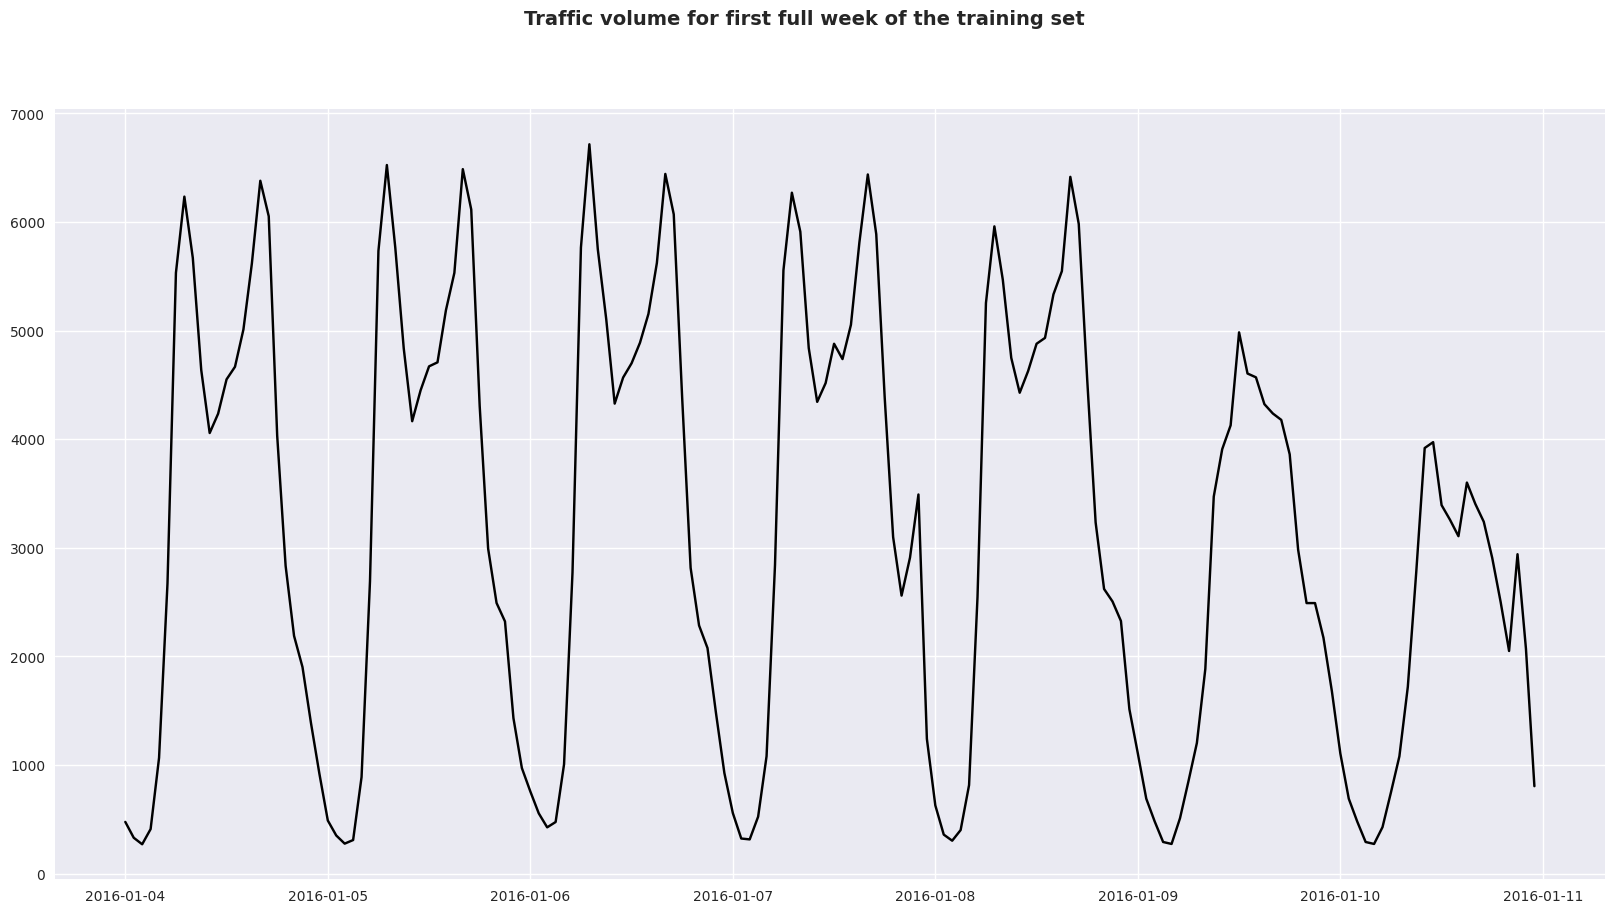

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))

# 2016/01/01 was a friday, we'd like to start the visualizations on a monday
start = 72
end = 72 + 168

fig.suptitle(
    "Traffic volume for first full week of the training set",
    fontsize=14,
    fontweight="bold",
)
ax.plot(
    traffic["ds"].to_numpy()[start:end],
    traffic["traffic_volume"].to_numpy()[start:end],
    color=col_data,
)

__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables. Note that we could have also used getML's Seasonal preprocessor (`getml.prepreprocessors.Seasonal()`), but in this case the information was already included in the dataset.

__Train/test split__

We use [getML's split functionality](https://docs.getml.com/latest/api/getml.data.split.html) to retrieve a lazily evaluated split column, that we can supply to the time series api below.

In [25]:
split = getml.data.split.time(traffic, "ds", test=getml.data.time.datetime(2018, 3, 15))

Split columns are columns of mere strings that can be used to subset the data by forming bolean conditions over them:

In [26]:
traffic[split == "test"]

name,ds,traffic_volume,holiday,hour,weekday,day,month,year
role,time_stamp,target,categorical,unused_float,unused_float,unused_float,unused_float,unused_float
unit,"time stamp, comparison only",,,,,,,
0,2018-03-15,577,No holiday,0,3,15,3,2018
1,2018-03-15 01:00:00,354,No holiday,1,3,15,3,2018
2,2018-03-15 02:00:00,259,No holiday,2,3,15,3,2018
3,2018-03-15 03:00:00,360,No holiday,3,3,15,3,2018
4,2018-03-15 04:00:00,910,No holiday,4,3,15,3,2018
...,...,...,...,...,...,...,...,...


### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). We use the [high-level time series api](https://docs.getml.com/latest/api/getml.data.TimeSeries.html) for this.

Under the hood, the time series api abstracts away a self cross join of the population table (`traffic`) that allows getML's feature learning algorithms to learn patterns from past observations.

In [27]:
time_series = getml.data.TimeSeries(
    population=traffic,
    split=split,
    time_stamps="ds",
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    lagged_targets=True,
)

time_series

data model

  population:
    columns:
    - holiday: categorical
    - traffic_volume: target
    - ds: time_stamp
    - hour: unused_float
    - weekday: unused_float
    - ...

    joins:
    - right: 'traffic'
      time_stamps: (population.ds, traffic.ds)
      relationship: 'many-to-many'
      memory: 604800.0
      horizon: 3600.0
      lagged_targets: True

  traffic:
    columns:
    - holiday: categorical
    - traffic_volume: target
    - ds: time_stamp
    - hour: unused_float
    - weekday: unused_float
    - ...


container

  population
      subset   name       rows   type
  0   test     traffic    4800   View
  1   train    traffic   19296   View

  peripheral
      name       rows   type     
  0   traffic   24096   DataFrame

## 2.Predictive modeling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [28]:
# The Seasonal preprocessor extracts seasonal
# components from the time stamps.
seasonal = getml.preprocessors.Seasonal()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_threads=1,    
    num_features=20,
)

predictor = getml.predictors.XGBoostRegressor()

__Build the pipeline__

In [29]:
pipe = getml.pipeline.Pipeline(
    tags=["memory: 7d", "horizon: 1h", "fast_prop"],
    data_model=time_series.data_model,
    preprocessors=[seasonal],
    feature_learners=[fast_prop],
    predictors=[predictor],
)

### 2.2 Model training

In [30]:
pipe.fit(time_series.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          

OK.
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Trying 373 features... 100% |██████████| [elapsed: 00:08, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
XGBoost: Training as predictor... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          

Trained pipeline.
Time taken: 0h:0m:9.246181



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='SquareLoss',
         peripheral=['traffic'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Seasonal'],
         share_selected_features=0.5,
         tags=['memory: 7d', 'horizon: 1h', 'fast_prop', 'container-lj9xWy'])

### 2.3 Model evaluation

In [31]:
pipe.score(time_series.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          



,date time,set used,target,mae,rmse,rsquared
0,2023-07-29 19:46:31,train,traffic_volume,200.4302,299.2045,0.9768
1,2023-07-29 19:46:31,test,traffic_volume,179.9515,269.631,0.9816


### 2.4 Studying features

__Feature correlations__

Correlations of the calculated features with the target

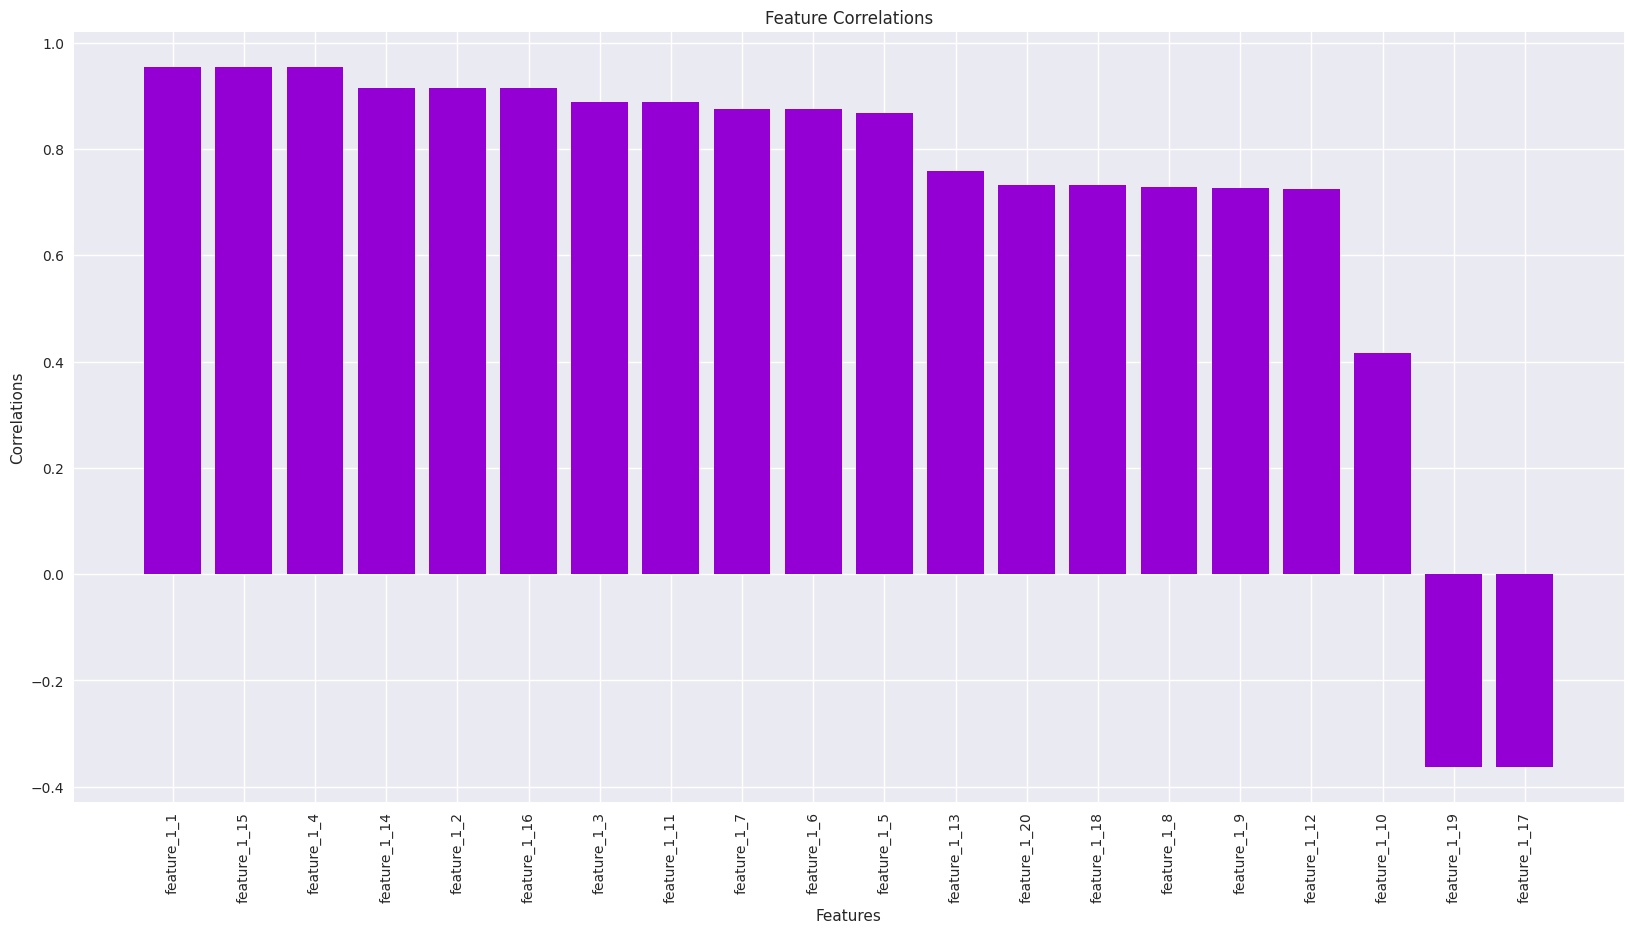

In [32]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color=col_getml)
plt.title("Feature Correlations")
plt.xlabel("Features")
plt.ylabel("Correlations")
plt.xticks(rotation="vertical")
plt.show()

__Feature importances__

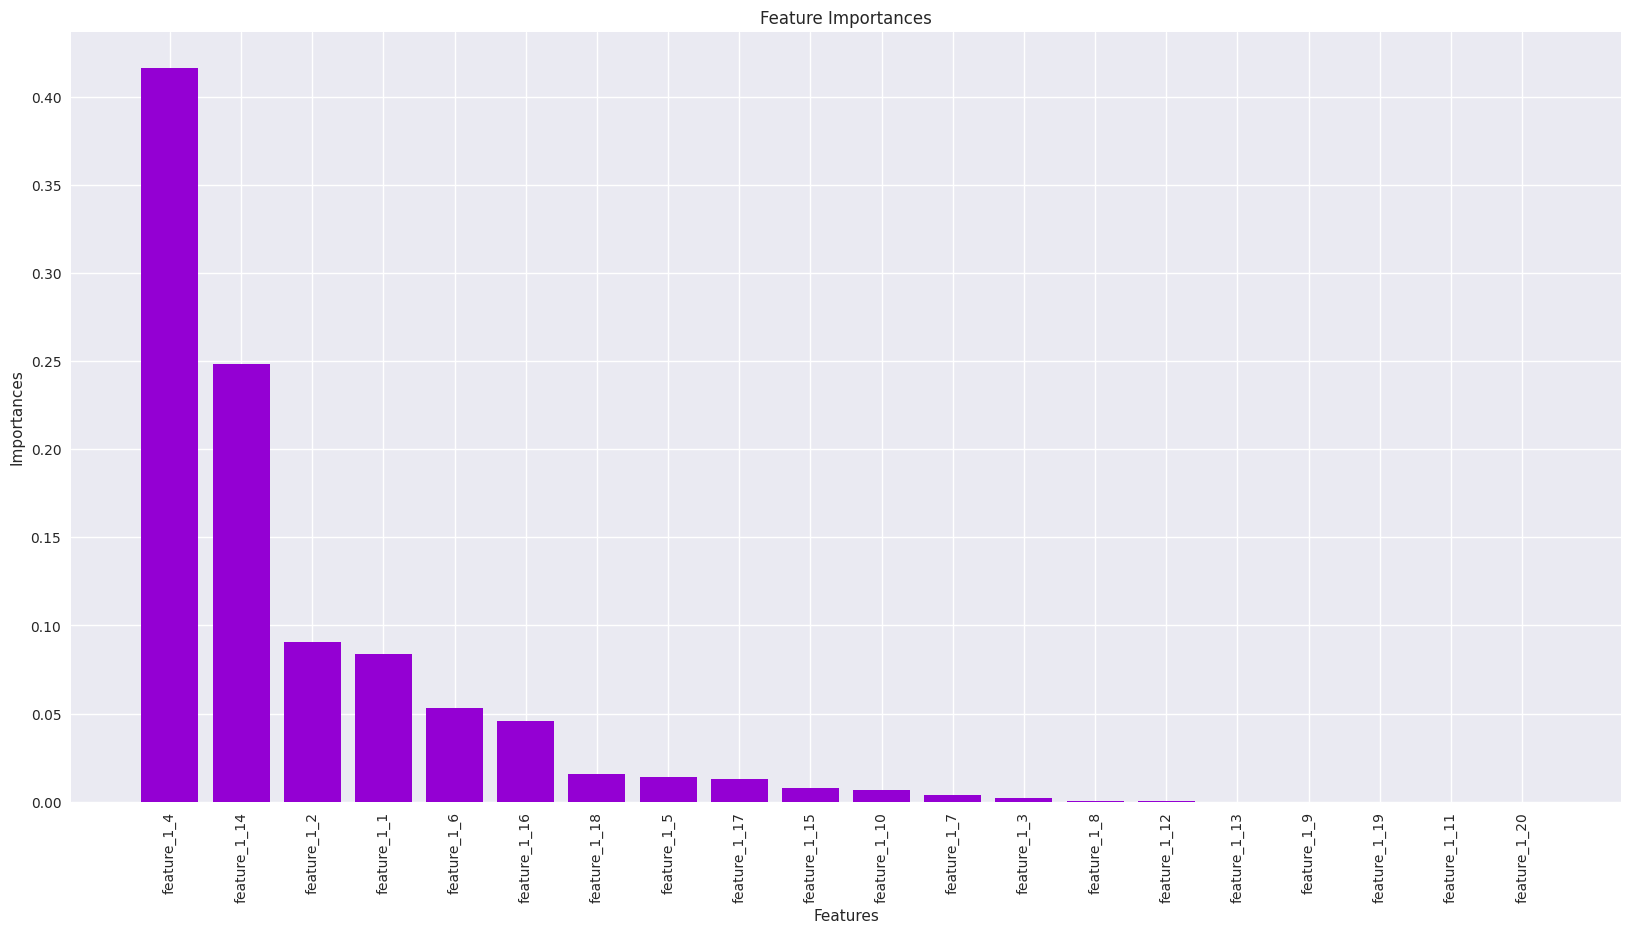

In [33]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color=col_getml)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importances")
plt.xticks(rotation="vertical")
plt.show()

__Visualizing the learned features__

We can also transpile the features as SQL code. Here, we show the most important feature.

In [34]:
by_importance = pipe.features.sort(by="importance")
by_importance[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_4";

CREATE TABLE "FEATURE_1_4" AS
SELECT FIRST( t2."traffic_volume" ORDER BY t2."ds, '+1.000000 hours'" ) AS "feature_1_4",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds, '+1.000000 hours'" <= t1."ds"
AND ( t2."ds, '+7.041667 days'" > t1."ds" OR t2."ds, '+7.041667 days'" IS NULL )
AND t1."hour( ds )" = t2."hour( ds )"
GROUP BY t1.rowid;
```

__Plot predictions & traffic volume vs. time__

We now plot the predictions against the observed values of the target for the first 7 days of the testing set. You can see that the predictions closely follows the original series. FastProp was able to identify certain patterns in the series, including:
- Day and night separation
- The daily commuting peeks (on weekdays)
- The decline on weekends



In [35]:
predictions = pipe.predict(time_series.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          



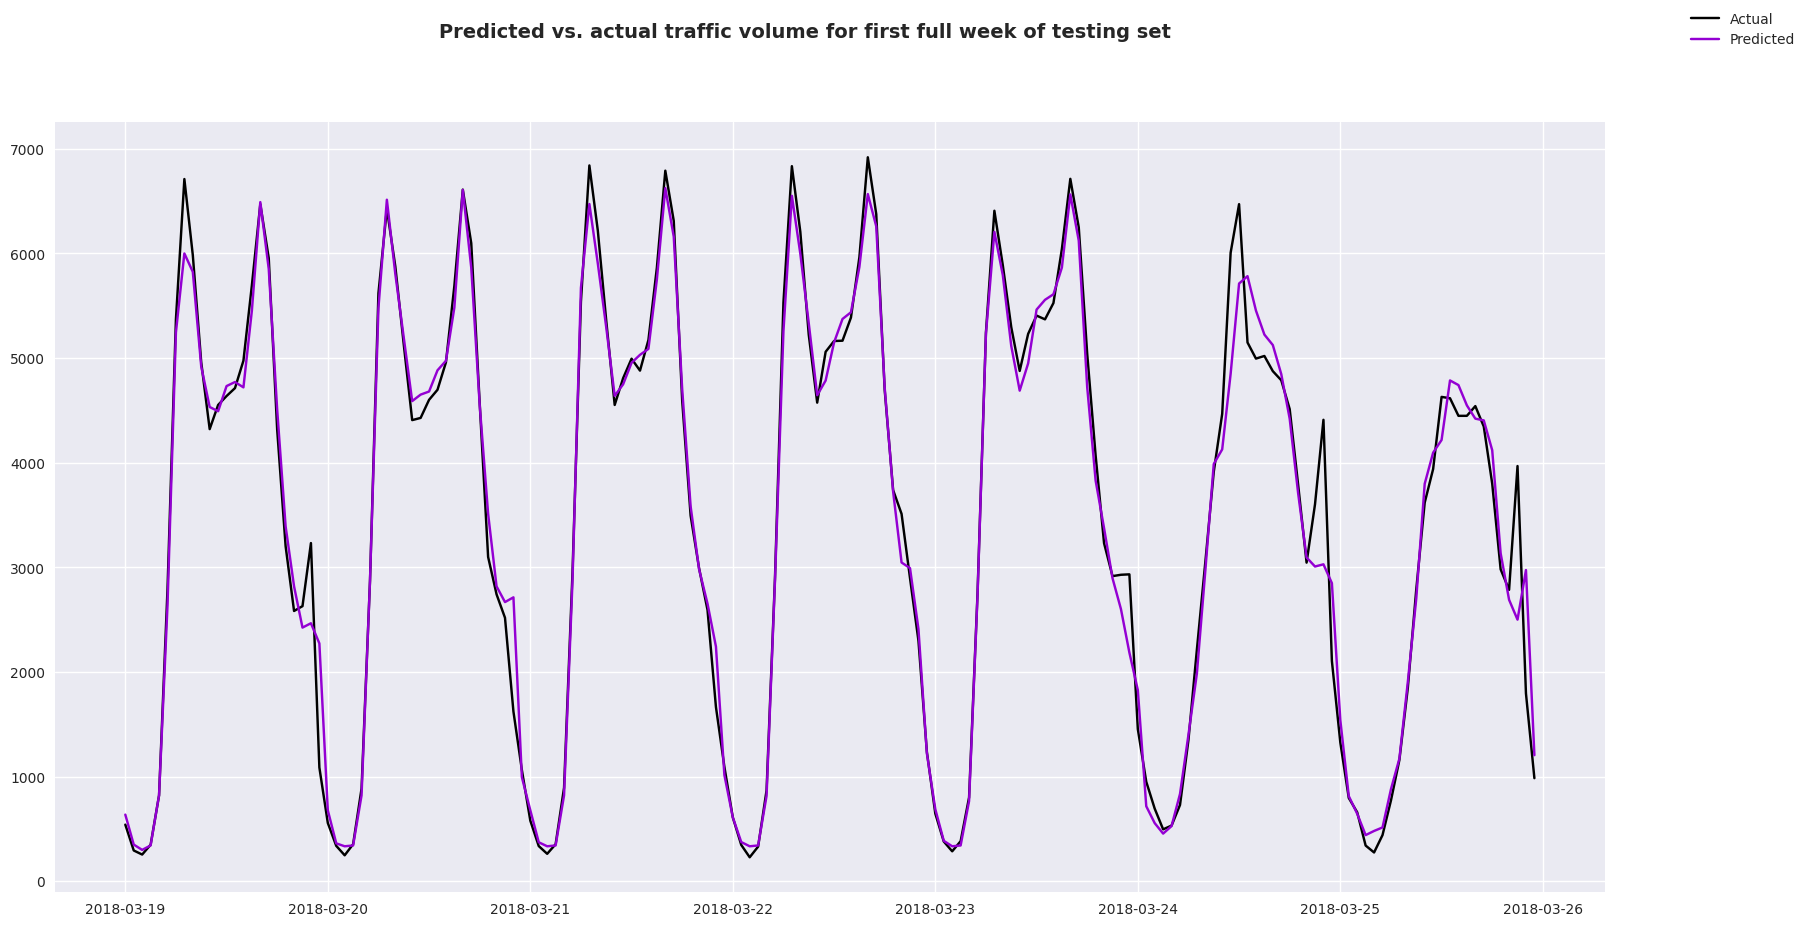

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))

# the test set starts at 2018/03/15 – a thursday; we introduce an offset to, once again, start on a monday
start = 96
end = 96 + 168

actual = time_series.test.population[start:end].to_pandas()
predicted = predictions[start:end]

ax.plot(actual["ds"], actual["traffic_volume"], color=col_data, label="Actual")
ax.plot(actual["ds"], predicted, color=col_getml, label="Predicted")
fig.suptitle(
    "Predicted vs. actual traffic volume for first full week of testing set",
    fontsize=14,
    fontweight="bold",
)
fig.legend()

### 2.5 Features

The most important feature looks as follows:

In [37]:
pipe.features.to_sql()[pipe.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_1_4";

CREATE TABLE "FEATURE_1_4" AS
SELECT FIRST( t2."traffic_volume" ORDER BY t2."ds, '+1.000000 hours'" ) AS "feature_1_4",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds, '+1.000000 hours'" <= t1."ds"
AND ( t2."ds, '+7.041667 days'" > t1."ds" OR t2."ds, '+7.041667 days'" IS NULL )
AND t1."hour( ds )" = t2."hour( ds )"
GROUP BY t1.rowid;
```

In [38]:
getml.engine.shutdown()

## 3. Conclusion

__Benchmarks against Prophet__

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. To retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross-validating the model on a rolling origin. This gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast. If you are interested in the full analysis please refer to the extended version of this [notebook](getml_examples/interstate94/interstate94.ipynb).


__Results__

We have benchmarked getML against Facebook’s Prophet library on a univariate time series with strong seasonal components.
Prophet is made for exactly these sort of data sets, so you would expect this to be a home run for Prophet. The opposite is true - getML’s relational learning algorithms outperform Prophet's 1-step ahead predictions by ~15 percentage points:

* R-squared Prophet: 83.3%
* R-squared getML: 98.1%